In [1]:
import numpy as np

In [2]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
import sys

root = '../../'
sys.path.append(root)
from HelpfulFunctions.batchCreation import createBatch

In [4]:
X_train = torch.tensor( np.load( root + "Features/train_features_vgg16_cifar10.npy" ) )
y_train = np.load( root + "Features/train_labels_vgg16_cifar10.npy" )

X_test = torch.tensor( np.load( root + "Features/test_features_vgg16_cifar10.npy" ) )
y_test = np.load( root + "Features/test_labels_vgg16_cifar10.npy" )

------

In [5]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [6]:
def customBatch(X_train, y_train, pos_sample_bal, batchSize, pos_label):    
    pos_i = [ i for i in range(len(X_train)) if y_train[i] == pos_label ]
    neg_i = list(set( range(len(X_train)) ) - set(pos_i))

    pos_sample_size = int(batchSize*pos_sample_bal)
    neg_sample_size = batchSize - pos_sample_size

    pos_i = random.sample( pos_i, pos_sample_size)
    neg_i = random.sample( neg_i, neg_sample_size)

    X_sample = torch.stack( [X_train[i] for i in pos_i+neg_i] )
    y_sample = [y_train[i] for i in pos_i+neg_i]
    return X_sample, y_sample

In [ ]:
def tripletLoss(bits, margin, batchSize, pos_sample_bal):
    model = nn.Sequential(  nn.Linear(4096,256),
                            nn.ReLU(),
                            nn.Linear(256, bits),
                            nn.Sigmoid()
                            )

    optimizer = optim.Adam( model.parameters() )
    criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                    margin=margin
                                    )

    loss_list = []
    lowest_loss = 10000
    no_improves = 0

    y_unique = list(set(y_train))
    for i in tqdm( range(10000) ):
        if batchSize != None:        
            xBatch, yBatch = customBatch( X_train, y_train, pos_sample_bal, batchSize, random.sample(y_unique,1)[0] )
        else:
            xBatch, yBatch = createBatch(X_train, y_train, batchSize)

        results = model(xBatch)
        results_np = results.detach().numpy()
        dMatrix = distance_matrix(results_np, results_np, p=1)

        APN_list = []

        for label in set(yBatch):
            pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]
            for anchor_i in pos_i_list:
                pos_i = [j for j in pos_i_list if j != anchor_i]
                APN_list += getAPN(anchor_i, pos_i, dMatrix)

        if len(APN_list) > 0:
            a_list = []
            p_list = []
            n_list = []

            for apn in APN_list:
                a_list.append(results[ apn[0] ])
                p_list.append(results[ apn[1] ])
                n_list.append(results[ apn[2] ])
            
            # === Improve Model ===
            optimizer.zero_grad()

            loss = criterion(torch.stack(a_list),
                            torch.stack(p_list),
                            torch.stack(n_list) )
            
            loss.backward()
            optimizer.step()

            loss_list.append( float(loss) )

        if float(loss) < lowest_loss:
            lowest_loss = float(loss)
            no_improves = 0
        
        if no_improves > 20: break

        if (i % 1000) == 0: 
            #print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
            
            if len(loss_list) != 0: print(i, sum(loss_list) / len(loss_list) )
            else: print(i, "Done")
            loss_list = []
        

    return model

bits = 32
margin = int(bits / 10)
batchSize = 40
pos_sample_bal = 0.50

model = tripletLoss(bits, margin, batchSize, pos_sample_bal)

  0%|          | 4/10000 [00:00<05:20, 31.19it/s]

0 2.942948341369629


 10%|█         | 1007/10000 [00:25<03:58, 37.70it/s]

1000 1.9271608543395997


 20%|██        | 2004/10000 [00:50<03:18, 40.38it/s]

2000 1.812083041369915


 30%|███       | 3006/10000 [01:15<02:49, 41.20it/s]

3000 1.8052034519910813


 40%|████      | 4006/10000 [01:40<02:29, 40.04it/s]

4000 1.7921518478989602


 50%|█████     | 5008/10000 [02:04<02:07, 39.19it/s]

5000 1.8077396576404572


 60%|██████    | 6005/10000 [02:29<01:37, 40.99it/s]

6000 1.7922130210399627


 70%|███████   | 7006/10000 [02:53<01:10, 42.77it/s]

7000 1.7986304881572723


 80%|████████  | 8004/10000 [03:18<00:48, 41.14it/s]

8000 1.7849444576203823


 90%|█████████ | 9004/10000 [03:42<00:24, 41.24it/s]

9000 1.79960019916296


100%|██████████| 10000/10000 [04:06<00:00, 40.53it/s]


----

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

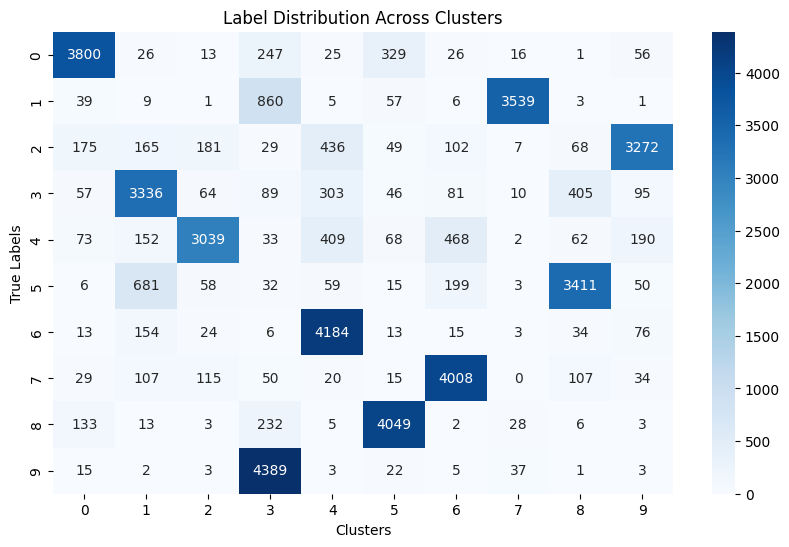

In [9]:
easyHeatmap(model(X_train).detach().numpy(), y_train)

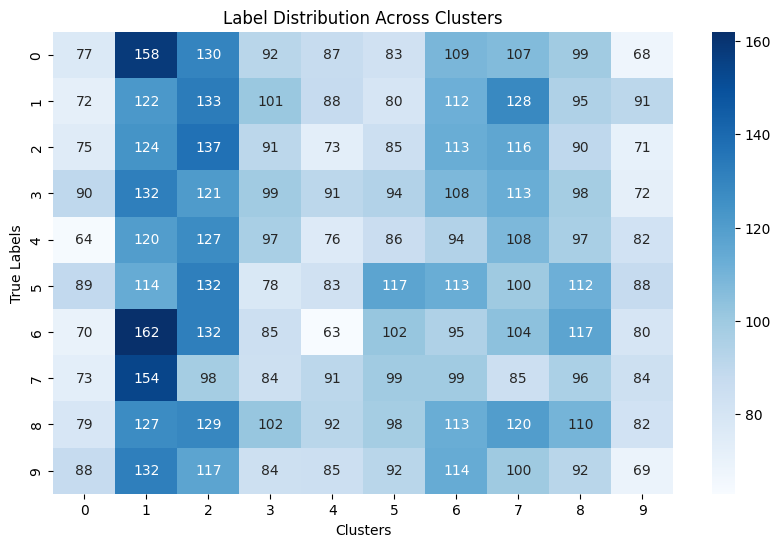

In [10]:
easyHeatmap(model(X_test).detach().numpy(), y_train)

In [11]:
def mean_average_precision(test_hashes, labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = labels[i]
        distances = np.abs(test_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.drop(index=i)
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [12]:
res = (model(X_test).detach().numpy() > 0.5).astype(int)
mean_average_precision( res , y_test)

100%|██████████| 10000/10000 [00:42<00:00, 236.38it/s]


0.7064897915929758